In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import cv2
import glob
import time
from moviepy.editor import VideoFileClip
%matplotlib inline

In [2]:
# Show first calibration image

images = glob.glob('./camera_cal/calibration*.jpg')

In [3]:
# Set up lists to hold object points and image points

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points. This is a 48x3 matrix
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)

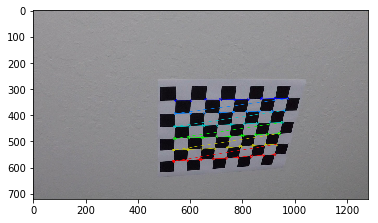

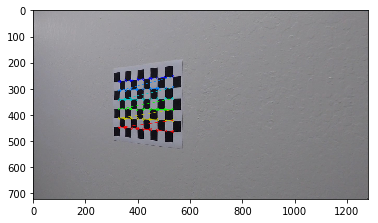

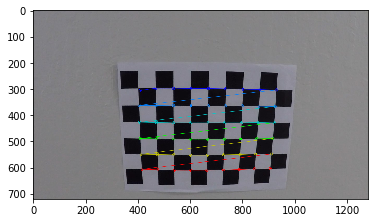

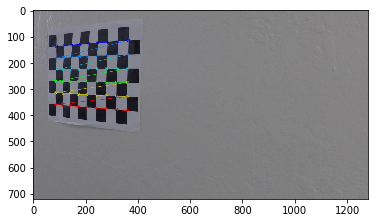

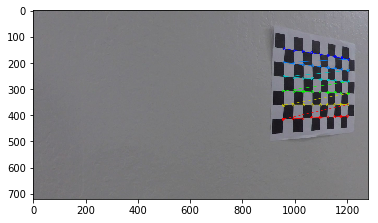

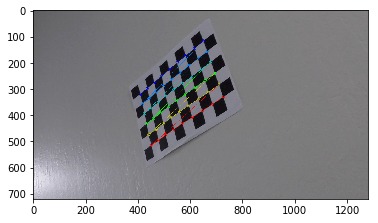

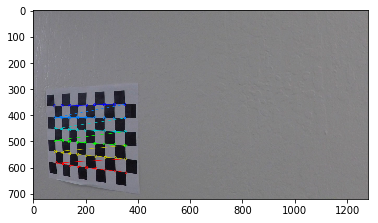

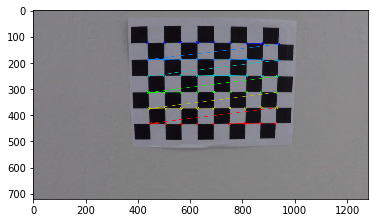

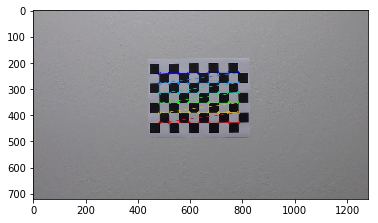

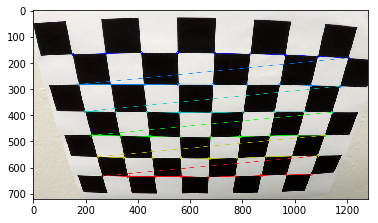

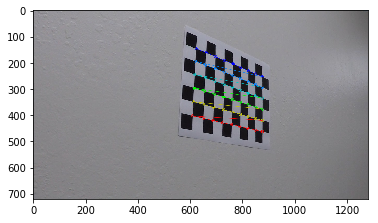

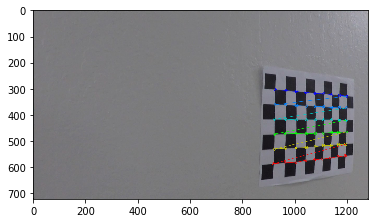

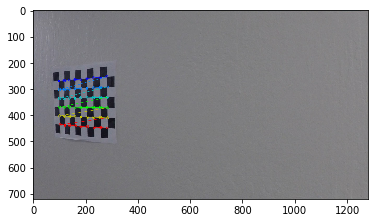

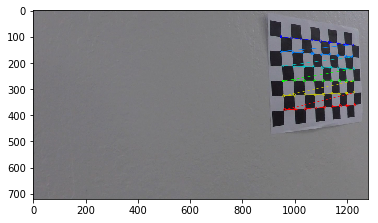

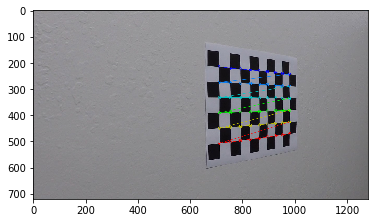

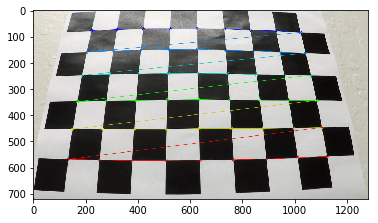

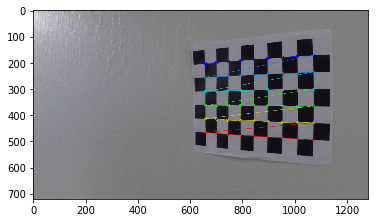

In [4]:
for fname in images:
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure()
        plt.imshow(img)

In [183]:
# Might want to change this so it isn't hardcoded
img_size = (1280, 720)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Return an undistorted image
def cal_undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

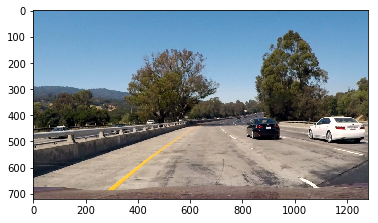

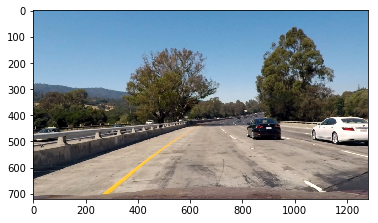

In [194]:
# Test the calibration for one image
#file = 'comma_example.jpg'
file = 'test1.jpg'
#file = 'test6.jpg'
img = mpimg.imread('./test_images/' + file)
plt.imshow(img)

img = cal_undistort(img)

plt.figure()
plt.imshow(img)

In [195]:
def corners_unwarp(img):
    img_size = (img.shape[1], img.shape[0])

    src = np.float32([(585,455),
                  (705,455), 
                  (190,720), 
                  (1130,720)])
    
    offset = 200
    dst = np.float32([(offset,0),
                  (img_size[0]-offset,0),
                  (offset,img_size[1]),
                  (img_size[0]-offset,img_size[1])])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

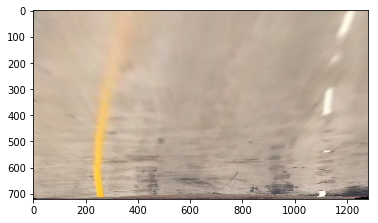

In [196]:
# Test the warping for a test image with a curved road
top_down, M, Minv = corners_unwarp(img)

plt.imshow(top_down)

Text(0.5,1,'LAB B-Channel')

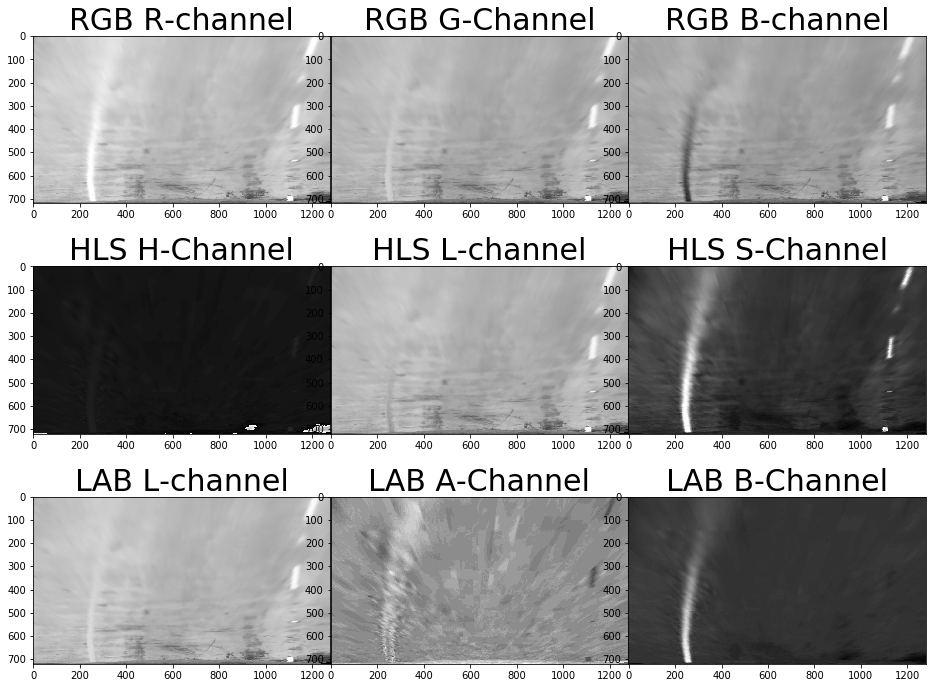

In [197]:
exampleImg_unwarp = top_down.copy()
# Visualize multiple color space channels
exampleImg_unwarp_R = exampleImg_unwarp[:,:,0]
exampleImg_unwarp_G = exampleImg_unwarp[:,:,1]
exampleImg_unwarp_B = exampleImg_unwarp[:,:,2]
exampleImg_unwarp_HLS = cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_RGB2HLS)
exampleImg_unwarp_H = exampleImg_unwarp_HLS[:,:,0]
exampleImg_unwarp_hL = exampleImg_unwarp_HLS[:,:,1]
exampleImg_unwarp_S = exampleImg_unwarp_HLS[:,:,2]
exampleImg_unwarp_LAB = cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_RGB2Lab)
exampleImg_unwarp_L = exampleImg_unwarp_LAB[:,:,0]
exampleImg_unwarp_A = exampleImg_unwarp_LAB[:,:,1]
exampleImg_unwarp_B2 = exampleImg_unwarp_LAB[:,:,2]
fig, axs = plt.subplots(3,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
axs[0].imshow(exampleImg_unwarp_R, cmap='gray')
axs[0].set_title('RGB R-channel', fontsize=30)
axs[1].imshow(exampleImg_unwarp_G, cmap='gray')
axs[1].set_title('RGB G-Channel', fontsize=30)
axs[2].imshow(exampleImg_unwarp_B, cmap='gray')
axs[2].set_title('RGB B-channel', fontsize=30)
axs[3].imshow(exampleImg_unwarp_H, cmap='gray')
axs[3].set_title('HLS H-Channel', fontsize=30)
axs[4].imshow(exampleImg_unwarp_hL, cmap='gray')
axs[4].set_title('HLS L-channel', fontsize=30)
axs[5].imshow(exampleImg_unwarp_S, cmap='gray')
axs[5].set_title('HLS S-Channel', fontsize=30)
axs[6].imshow(exampleImg_unwarp_L, cmap='gray')
axs[6].set_title('LAB L-channel', fontsize=30)
axs[7].imshow(exampleImg_unwarp_A, cmap='gray')
axs[7].set_title('LAB A-Channel', fontsize=30)
axs[8].imshow(exampleImg_unwarp_B2, cmap='gray')
axs[8].set_title('LAB B-Channel', fontsize=30)

In [198]:
def color_threshold(img, l_thresh=(220,255), b_thresh=(190,255)):
    img = np.copy(img)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    
    l_channel = hls[:,:,1]    
    lab_b = lab[:,:,2]

    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Normalize if there is yellow in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    b_binary = np.zeros_like(lab_b)
    b_binary[(lab_b > b_thresh[0]) & (lab_b <= b_thresh[1])] = 1
    
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(b_binary == 1) | (l_binary == 1)] = 1
    
    return combined_binary
    

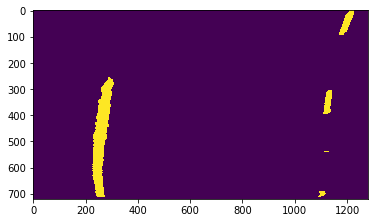

In [199]:
binary_warped = color_threshold(top_down)
plt.imshow(binary_warped)

In [200]:
## USE THIS TO PREPROCESS IMAGES
# RETURNS TOP DOWN BINARY IMAGE AND INVERSE MATRIX FOR UNDISTORTING

def preprocess(img):
    undistorted = cal_undistort(img)
    
    top_down, M, Minv = corners_unwarp(img)
    
    binary_warped = color_threshold(top_down)
    
    return binary_warped, Minv


In [201]:
def polyfit(binary_warped, visualize=False):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0 and len(lefty) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0 and len(righty) != 0:
        right_fit = np.polyfit(righty, rightx, 2)

    if visualize:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fit, right_fit, left_lane_inds, right_lane_inds

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


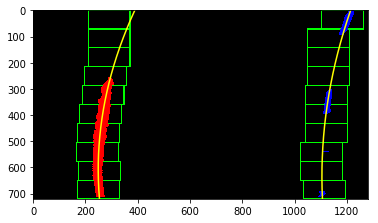

In [170]:
left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit(binary_warped, True)

In [171]:
def polyfit_prev(binary_warped, left_fit_prev, right_fit_prev, visualize=False):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) > 0 and len(lefty) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) > 0 and len(righty) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    if visualize:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

In [172]:
# Test the polyfit_prev function with a new image
'''
img2 = mpimg.imread('./test_images/test4.jpg')

binary_warped2, Minv = preprocess(img2)

polyfit_prev(binary_warped2, left_fit, right_fit, True)
'''


"\nimg2 = mpimg.imread('./test_images/test4.jpg')\n\nbinary_warped2, Minv = preprocess(img2)\n\npolyfit_prev(binary_warped2, left_fit, right_fit, True)\n"

In [173]:
def draw_on_lane(img, binary_warped, left_fit, right_fit, Minv):
    new_img = np.copy(img)
    if left_fit is None or right_fit is None:
        return original_img
    
    img_size = (binary_warped.shape[1], binary_warped.shape[0])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, img_size[1]-1, num=img_size[1])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=20)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=20)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_size[0], img_size[1])) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

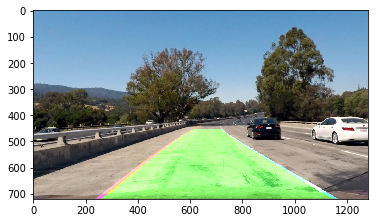

In [174]:
img_output = draw_on_lane(img, binary_warped, left_fit, right_fit, Minv)
plt.imshow(img_output)

In [22]:
def calculate_radius_and_distance(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_rad = 0
    right_rad = 0
    distance = 0
    
    img_size = (binary_warped.shape[1], binary_warped.shape[0])
    ploty = np.linspace(0, img_size[1]-1, img_size[1])
    y_eval = np.max(ploty)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) > 0 and len(rightx) > 0:
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        left_rad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_rad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        
    # Calculate how far the car is from the center of the lane
    if left_fit is not None and right_fit is not None:
        position = img_size[0] / 2
        left_x_intercept = left_fit[0]*img_size[1]**2 + left_fit[1]*img_size[1] + left_fit[2]
        right_x_intercept = right_fit[0]*img_size[1]**2 + right_fit[1]*img_size[1] + right_fit[2]
        lane_center = (left_x_intercept + right_x_intercept) / 2
                
        distance = (position - lane_center) * xm_per_pix
        
    return left_rad, right_rad, distance

In [23]:
left_rad, right_rad, distance = calculate_radius_and_distance(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

In [24]:
def draw_data(img, radius, distance):
    new_img = np.copy(img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(radius) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if distance > 0:
        direction = 'right'
    elif distance < 0:
        direction = 'left'
    abs_distance = abs(distance)
    text = '{:04.3f}'.format(abs_distance) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

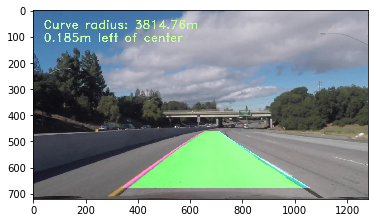

In [25]:
img_with_data = draw_data(img_output, (left_rad + right_rad)/2, distance)

plt.imshow(img_with_data)

In [26]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.recent_fits = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
    def add_fit(self, fit, inds):
        if fit is not None:
            if len(self.recent_fits) > 0:
                self.diffs = np.absolute(self.recent_fits[len(self.recent_fits)-1] - fit)
    
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.recent_fits) > 0:
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.recent_fits.append(fit)
                if len(self.recent_fits) > 5:
                    # Remove oldest fit
                    self.recent_fits.pop(0)
                self.best_fit = np.average(self.recent_fits, axis=0)
        else:
            self.detected = False

            if len(self.recent_fits) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.recent_fits, axis=0)

In [202]:
def process_image(img):

    new_img = np.copy(img)
    
    binary_warped, Minv = preprocess(new_img)

    if not left_line.detected or not right_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit(binary_warped)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit_prev(binary_warped, left_line.best_fit, right_line.best_fit)
    
    left_line.add_fit(left_fit, left_lane_inds)
    right_line.add_fit(right_fit, right_lane_inds)
    
    if left_line.best_fit is not None and right_line.best_fit is not None:
        left_rad, right_rad, distance = \
            calculate_radius_and_distance(binary_warped, left_line.best_fit, right_line.best_fit, left_lane_inds, right_lane_inds)
        
        output_img = draw_on_lane(new_img, binary_warped, left_line.best_fit, right_line.best_fit, Minv)
        output_img = draw_data(output_img, (left_rad+right_rad)/2, distance)
    else:
        output_img = new_img
        
    return output_img
    

In [203]:
left_line = Line()
right_line = Line()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:30<00:00, 14.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min, sys: 2.79 s, total: 2min 3s
Wall time: 1min 31s


In [145]:
left_line = Line()
right_line = Line()

video_output1 = 'challenge_video_output.mp4'
video_input1 = VideoFileClip('challenge_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:15<00:00,  5.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 26s, sys: 1.46 s, total: 1min 27s
Wall time: 1min 16s


TypeError: Image data cannot be converted to float

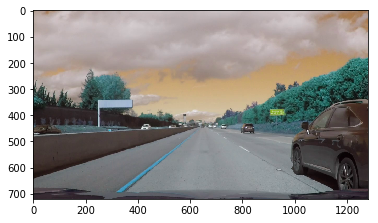

In [29]:
cap = cv2.VideoCapture('challenge_video.mp4')

#left_line = Line()
#right_line = Line()

#output = process_image(img)

#plt.imshow(output)

frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

for i in range(frames):
    flag, frame = cap.read()
    
    plt.imshow(frame)
    
    if cv2.waitKey(1) == 27:
        break